# MNIST Data Image Recognition

In this notebook we propose a simple Neural Network (NN) architecture to recognize hand-written digits. We use the MNIST dataset, consisting of 70,000 images split into 60,000 for training and 10,000 for validation.

The aim of this project is two-fold. First, to emphasize the importance of the choice of hyperparameters and regularization in NNs, starting with a simple fully connected neural network (FCNN) using the well-known MNIST dataset as a prototypical benchmark. Second, to assert the power of Convolutional Neural Networks (CNNs) for image recognition tasks, which significantly outperform simpler NN architectures for this type of tasks.

Starting with the FCNN, following the literature on this task we begin with a simple benchmark architecture, consisting of one hidden-layer with 128 nodes, a ReLU activation function, and an output softmax activation function for the output layer, combined with a cross-validation entropy loss-function, the standard choice for non-binary classification. We also opt for an ADAM optimizer with default 0.001 learning rate, and 32-sized mini-batches. We compute the loss function and accuracy on both the training and validation sets to assess the efficiency of the NN.

We then perform a hyperparameter search over various hyperparameters, evaluating the error on the validation set for each combination of hyperparameters and we select the most accurate ones. Considering the simplicity of the images involved we opt to stick with having just one hidden layer, and vary the other hyperparameters as follows:

- learning rates = 0.0001, 0.001, 0.01
- batch sizes = 32, 64, 128
- epochs = 10, 20, 50
- hidden units = 64, 128, 256
- activations = relu, tanh
- optimizers = adam, sgd, rmsprop

We train and test all 486 combinations of these hyperparameters and select the 5 combinations which yield the best accuracy on the validation set. We then add regularization to the picture to reduce overiftting, and compare the performances of the various models. 
Here we opt for a grid search, rather than a randomized one, in order to better visualize how the accuracy of the model changes, as a pedagogical introduction to the topic.

We then move on to a CNN architecture to tackle the same problem. Again, we start with a benchmark model and then perform a hyperparameter search, now starting with a randomized hyperparameter search from the start, and compare the performace of the two types of models.

In [5]:
#import libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt
import itertools
import random
import time

In [6]:
# Load MNIST dataset from tf and reshape

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Print dataset statistics
print(f"Number of training images: {train_images.shape[0]}")
print(f"Image dimensions: {train_images.shape[1]}x{train_images.shape[2]}")
print(f"First label: {train_labels[0]} \n ")

# Normalize the image data RGB
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Print shape of train and test images, before and after reshaping
print(f"Dimension of array of training images: {train_images.shape}")
print(f"Dimension of array of training labels: {train_labels.shape}")
print(f"So, our training set has {train_images.shape[0]} examples, with {train_images.shape[1]}x{train_images.shape[2]} pixels per example")
print(f"Flattening out the image from a {train_images.shape[1]}x{train_images.shape[2]} array to a {train_images.shape[1]*train_images.shape[2]}-dimensional vector")


# Flatten each 28x28 image into a vector of size 784 (28*28)
x_train = train_images.reshape(-1, train_images.shape[1] * train_images.shape[2])
x_test = test_images.reshape(-1, test_images.shape[1] * test_images.shape[2])

y_train = train_labels
y_test = test_labels


# Print the new shape to verify
print(f"\nFlattened training images shape: {x_train.shape}")
print(f"Flattened test images shape: {x_test.shape}")

print(f"\nTraining images labels shape: {y_train.shape}")
print(f"Test images labels shape: {y_test.shape}")

# Seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

Number of training images: 60000
Image dimensions: 28x28
First label: 5 
 
Dimension of array of training images: (60000, 28, 28)
Dimension of array of training labels: (60000,)
So, our training set has 60000 examples, with 28x28 pixels per example
Flattening out the image from a 28x28 array to a 784-dimensional vector

Flattened training images shape: (60000, 784)
Flattened test images shape: (10000, 784)

Training images labels shape: (60000,)
Test images labels shape: (10000,)


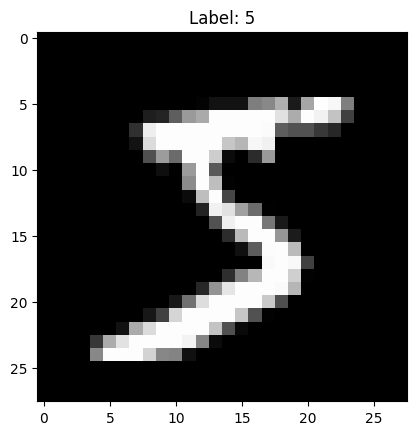

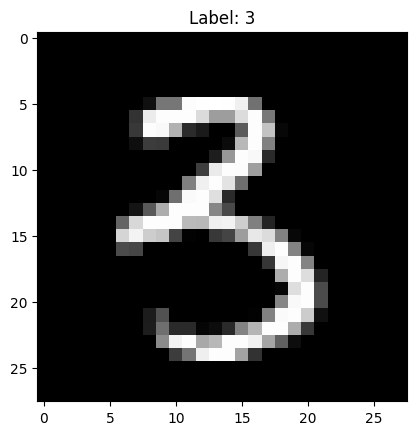

In [7]:
# Test plotting  loaded images
plt.imshow(train_images[0], cmap='gray')
plt.title(f"Label: {train_labels[0]}")
plt.show()


plt.imshow(test_images[5000], cmap='gray')
plt.title(f"Label: {test_labels[5000]}")
plt.show()

As we previously stated, we begin with a benchmark NN with the following details:
- one hidden layer, 128 nodes, ReLU activation function
- output layer, 10 nodes, softmax activation function, cross-entropy loss function
- ADAM optimizer, 0.001 learning rate (default)
- 32-sized mini-batches (default)
- 10 training epochs

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.8792 - loss: 0.4239 - val_accuracy: 0.9588 - val_loss: 0.1345
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9645 - loss: 0.1221 - val_accuracy: 0.9699 - val_loss: 0.0983
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9765 - loss: 0.0788 - val_accuracy: 0.9726 - val_loss: 0.0868
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9832 - loss: 0.0564 - val_accuracy: 0.9745 - val_loss: 0.0817
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9877 - loss: 0.0414 - val_accuracy: 0.9758 - val_loss: 0.0810
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9919 - loss: 0.0307 - val_accuracy: 0.9755 - val_loss: 0.0837
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9945 - loss: 0.0229 - val_accuracy: 0.9760 - val_loss: 0.0814
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9953 - loss: 0

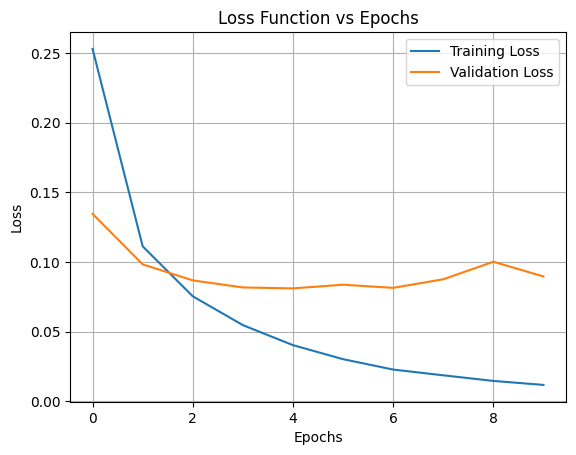

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9725 - loss: 0.0999     
Final training accuracy: 0.9969
Final dev accuracy: 0.9767

Final training error: 0.30666589736938477 %
Final dev error: 2.3299992084503174 %


In [8]:
# Benchmark Neural Network (without regularization)


# Number of nodes in hidden and output layers
n1 = 128
nout = 10

model = models.Sequential([
    layers.Dense(n1, activation='relu', input_shape=(28*28,)),
    layers.Dense(nout, activation='softmax')
])


model.summary()


# Compile the model with ADAM
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model and save the training history
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Evaluate the model
model.evaluate(x_test, y_test)

training_error = (1 - history.history['accuracy'][-1])
dev_error = (1 - history.history['val_accuracy'][-1])

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")

print(f"\nFinal training error: {training_error*100} %")
print(f"Final dev error: {dev_error*100} %")


We find the following performance for the benchmark NN:
- Final training error: 0.31 %
- Final dev error: 2.33 %
The variance amounts to 2.02%. This can be anticipated by considering the plots of the loss function vs epochs for the training set, which decreases steadily, and for the validation set, which plateaus after ~4 epochs. This could be due to overfitting. We will address this later by employing regularization. 

We now explore the model more thoroughly by performing a systematic search of hyperparameters over a grid (takes some time to run).

In [6]:
# Hyperparameter grid
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [32, 64, 128]
epochs = [10, 20, 50]
hidden_units = [64, 128, 256]
activations = ['relu', 'tanh']
optimizers = ['adam', 'sgd', 'rmsprop']


# Function to create and compile model
def create_model(learning_rate, batch_size, hidden_units, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# List to store results
results = []

# Grid search
for lr, batch, epoch, units, activation, optimizer in itertools.product(
    learning_rates, batch_sizes, epochs, hidden_units, activations, optimizers):
    
    print(f"Training with lr={lr}, batch_size={batch}, epochs={epoch}, units={units}, activation={activation}, optimizer={optimizer}")
    
    model = create_model(lr, batch, units, activation, optimizer)
    
    # Train the model
    history = model.fit(x_train, y_train, 
                        epochs=epoch, 
                        batch_size=batch, 
                        validation_data=(x_test, y_test), 
                        verbose=0)
    
    # Evaluate model performance
    val_accuracy = history.history['val_accuracy'][-1]
    
    # Calculate dev error (1 - validation accuracy)
    dev_error = 1 - val_accuracy
    
    # Append results
    results.append({
        'learning_rate': lr,
        'batch_size': batch,
        'epochs': epoch,
        'hidden_units': units,
        'activation': activation,
        'optimizer': optimizer,
        'val_accuracy': val_accuracy,
        'dev_error': dev_error
    })

# Sort results by validation accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)

# Print the top 5 results
print("\nTop 5 hyperparameter choices:")
for i, result in enumerate(sorted_results[:5]):
    print(f"\nRank {i+1}:")
    print(f"Learning rate: {result['learning_rate']}")
    print(f"Batch size: {result['batch_size']}")
    print(f"Epochs: {result['epochs']}")
    print(f"Hidden units: {result['hidden_units']}")
    print(f"Activation: {result['activation']}")
    print(f"Optimizer: {result['optimizer']}")
    print(f"Validation accuracy: {result['val_accuracy']:.4f}")
    print(f"Dev error: {result['dev_error'] * 100:.2f}%")


Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=32, epochs=10, units=128, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=32, epochs=10, units=128

Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=20, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=sgd
Training with lr=0.0001, batch_size=64, epochs=50, units=64, activation=tanh, optimizer=rmsprop
Training with lr=0.0001, batch_size=64, epochs=50, units=128, activation=relu, optimizer=adam
Training with lr=0.0001, batch_size=64, epochs=50, units=128

Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=10, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=32, epochs=20, units=64, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=32, epochs=20, units=64, activati

Training with lr=0.001, batch_size=64, epochs=50, units=128, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=adam
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=sgd
Training with lr=0.001, batch_size=64, epochs=50, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.001, batch_size=128, epochs=10, units=64, activation=relu, optimizer=adam
Training with lr=0.001, batch_size=128, epochs=10, units=64, activation=relu, optimizer=sgd
Training with lr=0.001, batch_size=128, epochs=10, units=64, acti

Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=32, epochs=20, units=256, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=32, epochs=50, units=64, activation=r

Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=128, activation=tanh, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=relu, optimizer=rmsprop
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=tanh, optimizer=adam
Training with lr=0.01, batch_size=128, epochs=10, units=256, activation=tanh, optimizer=sgd
Training with lr=0.01, batch_size=128, epochs=10, units=256, acti

NEW BEST 5:

Rank 1:
Learning rate: 0.01
Batch size: 64
Epochs: 50
Hidden units: 256
Activation: tanh
Optimizer: rmsprop
Validation accuracy: 0.9833
Dev error: 1.67%

Rank 2:
Learning rate: 0.001
Batch size: 32
Epochs: 50
Hidden units: 256
Activation: tanh
Optimizer: rmsprop
Validation accuracy: 0.9832
Dev error: 1.68%

Rank 3:
Learning rate: 0.0001
Batch size: 128
Epochs: 50
Hidden units: 256
Activation: relu
Optimizer: adam
Validation accuracy: 0.9830
Dev error: 1.70%

Rank 4:
Learning rate: 0.01
Batch size: 64
Epochs: 50
Hidden units: 256
Activation: relu
Optimizer: adam
Validation accuracy: 0.9829
Dev error: 1.71%

Rank 5:
Learning rate: 0.0001
Batch size: 32
Epochs: 50
Hidden units: 256
Activation: tanh
Optimizer: rmsprop
Validation accuracy: 0.9828
Dev error: 1.72%

Old Best 5 hyperparameter choices:

Rank 1:
Learning rate: 0.01
Batch size: 64
Epochs: 50
Hidden units: 256
Activation: relu
Optimizer: adam
Validation accuracy: 0.984
Dev error: 1.59%

Rank 2:
Learning rate: 0.001
Batch size: 128
Epochs: 50
Hidden units: 256
Activation: relu
Optimizer: adam
Validation accuracy: 0.984
Dev error: 1.60%

Rank 3:
Learning rate: 0.01
Batch size: 64
Epochs: 50
Hidden units: 256
Activation: tanh
Optimizer: rmsprop
Validation accuracy: 0.9831
Dev error: 1.69%

Rank 4:
Learning rate: 0.01
Batch size: 32
Epochs: 50
Hidden units: 256
Activation: relu
Optimizer: rmsprop
Validation accuracy: 0.9827
Dev error: 1.73%

Rank 5:
Learning rate: 0.0001
Batch size: 32
Epochs: 50
Hidden units: 256
Activation: relu
Optimizer: adam
Validation accuracy: 0.9826
Dev error: 1.74%

Compred to the previous benchmark scenario, which achieved a dev error = 2.33%, the best set of hyperparameters here yields an improvement of 0.7%.

We now focus on the most accurate architecture of the above and inspect it in more detail.

In [ ]:
# Most Accurate Neural Network (Rank 1)

# Hyperparameters 'best' (b)
lr_b = 0.01
batch_b = 64
epoch_b = 50
units_b = 256
activation_b = 'tanh'
optimizer_b = 'rmsprop'

# Function to create and compile model
def create_model(learning_rate, batch_size, hidden_units, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


model = create_model(lr_b, batch_b, units_b, activation_b, optimizer_b)

# Train the model
history = model.fit(x_train, y_train, 
                        epochs=epoch_b, 
                        batch_size=batch_b, 
                        validation_data=(x_test, y_test), 
                        verbose=0)


    
# Evaluate model performance
training_error = (1 - history.history['accuracy'][-1])

val_accuracy = history.history['val_accuracy'][-1]
dev_error = 1 - val_accuracy


# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs Epochs')
plt.legend()
plt.grid()
plt.show()


print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")

print(f"\nFinal training error: {training_error*100} %")
print(f"Final dev error: {dev_error*100} %")

While the loss function on the training set converges extremely well, the loss function on the validation set stops decreasing after around 10 epochs, and slightly increases reaching 50 epochs, for all 3 most accurate models. This suggests an overfitting of the training data, which motivates us to include regularization.

We now add dropout regularization to the model. Again, we begin by considering a benchmark model with a fixed dropout rate of 0.3, and then scan over various rates to select the values that work best.

In [12]:
# Hyperparameters 'best' (b) with dropout

lr_b = 0.01
batch_b = 64
epoch_b = 50
units_b = 256
activation_b = 'tanh'
optimizer_b = 'rmsprop'

# Function to create and compile model
def create_model(learning_rate, batch_size, hidden_units, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dropout(0.3),  # Add Dropout layer with a dropout rate of 0.3
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Create and train the model
model = create_model(lr_b, batch_b, units_b, activation_b, optimizer_b)

history = model.fit(x_train, y_train, 
                    epochs=epoch_b, 
                    batch_size=batch_b, 
                    validation_data=(x_test, y_test), 
                    verbose=0)

# Evaluate model performance
training_error = (1 - history.history['accuracy'][-1])
val_accuracy = history.history['val_accuracy'][-1]
dev_error = 1 - val_accuracy

# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Print metrics
print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"\nFinal training error: {training_error*100:.2f} %")
print(f"Final dev error: {dev_error*100:.2f} %")


KeyboardInterrupt: 

We note a slight improvement in the validation error, from 1.68% of the best benchmark scenario without regularazion down to 1.66% with dropout. We now let the dropout rate vary from 0.1 to 0.6 in steps of 0.1.

In [ ]:
# Hyperparameters 'best' (b) with dropout
lr_b = 0.01
batch_b = 64
epoch_b = 50
units_b = 256
activation_b = 'tanh'
optimizer_b = 'rmsprop'


# Function to create and compile model
def create_model_dropout(learning_rate, batch_size, hidden_units, dropout_rate, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dropout(dropout_rate),  # Add Dropout layer with a dropout rate of 0.3
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


# Store results
dropout_rates = np.arange(0.1, 0.6, 0.1)  # Dropout rates to test
val_errors = []  # Store validation errors
training_errors = []  # Store training errors


for drop_rate in dropout_rates:
    # Create and train the model
    print(f"Testing Dropout Rate: {drop_rate}")
    model = create_model_dropout(lr_b, batch_b, units_b, drop_rate, activation_b, optimizer_b)
    
    history = model.fit(x_train, y_train, 
                        epochs=epoch_b, 
                        batch_size=batch_b, 
                        validation_data=(x_test, y_test), 
                        verbose=0)
    
    # Evaluate model performance
    training_error = (1 - history.history['accuracy'][-1])
    val_accuracy = history.history['val_accuracy'][-1]
    dev_error = 1 - val_accuracy


    # Store results
    training_errors.append(training_error)
    val_errors.append(dev_error)
    
    # Print metrics
    print(f"Dropout Rate: {drop_rate}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Training error: {training_error*100:.2f}%")
    print(f"Validation error: {dev_error*100:.2f}%")
    print("\n")

# Plot validation error vs dropout rate
plt.plot(dropout_rates, val_errors, label='Validation Error', marker='o')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Error')
plt.title('Validation Error vs Dropout Rate')
plt.legend()
plt.grid()
plt.show()

The validation error achieves the lowest values for dropout rates 0.3 and 0.4. We now zoom around this interval further, testing dropout rates going from 0.25 to 0.45 in steps of 0.02 

In [ ]:
# Hyperparameters 'best' (b) with dropout
lr_b = 0.01
batch_b = 64
epoch_b = 50
units_b = 256
activation_b = 'tanh'
optimizer_b = 'rmsprop'


# Function to create and compile model
def create_model_dropout(learning_rate, batch_size, hidden_units, dropout_rate, activation, optimizer):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units, activation=activation, input_shape=(28*28,)),
        tf.keras.layers.Dropout(dropout_rate),  # Add Dropout layer with a dropout rate of 0.3
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    # Compile model with given optimizer and learning rate
    model.compile(optimizer=optimizer, 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


# Store results
dropout_rates = np.arange(0.25, 0.45, 0.02)  # Dropout rates to test
val_errors = []  # Store validation errors
training_errors = []  # Store training errors


for drop_rate in dropout_rates:
    # Create and train the model
    print(f"Testing Dropout Rate: {drop_rate}")
    model = create_model_dropout(lr_b, batch_b, units_b, drop_rate, activation_b, optimizer_b)
    
    history = model.fit(x_train, y_train, 
                        epochs=epoch_b, 
                        batch_size=batch_b, 
                        validation_data=(x_test, y_test), 
                        verbose=0)
    
    # Evaluate model performance
    training_error = (1 - history.history['accuracy'][-1])
    val_accuracy = history.history['val_accuracy'][-1]
    dev_error = 1 - val_accuracy


    # Store results
    training_errors.append(training_error)
    val_errors.append(dev_error)
    
    # Print metrics
    print(f"Dropout Rate: {drop_rate}")
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Training error: {training_error*100:.2f}%")
    print(f"Validation error: {dev_error*100:.2f}%")
    print("\n")

# Plot validation error vs dropout rate
plt.plot(dropout_rates, val_errors, label='Validation Error', marker='o')
plt.xlabel('Dropout Rate')
plt.ylabel('Validation Error')
plt.title('Validation Error vs Dropout Rate')
plt.legend()
plt.grid()
plt.show()

The best dev accuracy is obtained for a dropout rate of 0.41, which yields a training error of 0.60% and a validation error of 1.56%, yielding significant improvement compared to the analogous NN without dropout which had a dev error od 1.68%.

As a last step, we perform a final, scarcer, hyperparameter search with this fixed dropout rate of 0.41, to verify if these adjustments can lead to further improvements on the dev accuracy.

In [ ]:
# Define ranges for hyperparameters

learning_rates = [0.001, 0.01, 0.03]
hidden_units = [128, 256, 512]
batch_sizes = [32, 64, 128]

# Iterate over all combinations
for lr, units, batch in itertools.product(learning_rates, hidden_units, batch_sizes):
    print(f"Testing: lr={lr}, units={units}, batch_size={batch}")
    model = create_model_dropout(lr, batch, units, dropout_rate=0.41, 
                                 activation='tanh', optimizer='rmsprop')
    
    history = model.fit(x_train, y_train,
                        epochs=10,  # Use fewer epochs for quick evaluation
                        batch_size=batch,
                        validation_data=(x_test, y_test),
                        verbose=0)
    
    val_accuracy = history.history['val_accuracy'][-1]
    dev_error = 1 - val_accuracy
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation error: {dev_error*100:.2f}%")


The best accuracy is obtained for a learning rate = 0.01, 512 units, batch size = 64, which yields a validation accuracy = 0.9851, i.e. a dev error = 1.49%.

This represents a substantial improvement compared to the initial benchmark scenario (dev error = 2.33%) and also to the previously chosen "best scenario" without dropout (dev error =  1.59%). This highlights the importance of both the choice of hyperparameters and the regularization when selecting a functioning model.

# CNN for MNIST Dataset

We now move on to consider a CNN for the same MNIST digit recognition.

As we just did for the FCNN, we begin with a benchmark model before employing a more complete randomized hyperparameter search and, possibly, regularization.

Following the common practice for image recognition, we employ a sequence of a convolutional layer followed by a max-pooling layer, twice, then followed by two flattened, dense layers and a softmax output.

In this benchmark model, each convolutional layer applies ReLU activation and uses a 3×3 filter size to extract local features from the input images. The first convolutional layer contains 32 filters, while the second has 64 filters, allowing the model to progressively learn more complex patterns. Each convolutional layer is followed by a 2×2 max-pooling layer, which reduces spatial dimensions and enhances computational efficiency.

After feature extraction, the output is flattened and passed through a fully connected layer with 128 neurons using ReLU activation. Finally, the model concludes with a softmax output layer with 10 neurons, corresponding to the 10 digit classes in the MNIST dataset.

The model is optimized using the Adam optimizer, which is well-suited for adaptive learning rate adjustments, and trained using the sparse categorical cross-entropy loss function. The training process spans 10 epochs, with performance tracked on the validation dataset.

In [ ]:
# Benchmark Convolutional Neural Network (CNN)

# Reshape input data for CNN and normalize pixels
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Model architecture
model = models.Sequential([
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(2, 2),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten the output of the convolutional layers
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation='relu'),

    # Output layer (10 classes for MNIST digits)
    layers.Dense(10, activation='softmax')
])

model.summary()

# Compile the model with ADAM optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model and save the training history
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

# Plot the loss function
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs Epochs')
plt.legend()
plt.grid()
plt.show()

# Evaluate the model
model.evaluate(x_test, y_test)

training_error = (1 - history.history['accuracy'][-1])
dev_error = (1 - history.history['val_accuracy'][-1])

print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final dev accuracy: {history.history['val_accuracy'][-1]:.4f}")

print(f"\nFinal training error: {training_error*100} %")
print(f"Final dev error: {dev_error*100} %")


This yields:
- Final training accuracy: 0.9838
- Final dev accuracy: 0.9839
- Final training error: 1.623 %
- Final dev error: 1.61 %

As a semi-random, benchmark model, this already yields a superior performance compared to the initial benchmark FCNN model (dev error = 2.33%) and also virtually no overfitting!

We now go further to consider a hyperparameter search. In contrast to the hyperparameter grid used for the FCNN, which was chosen for pedagogical clarity, we now employ a randomized hyperparameter search. This allows us to explore a broader range of hyperparameters while keeping computational costs manageable.

Specifically, we tune the number of filters in each convolutional layer, ranging from 32 to 128 in steps of 32, and the kernel size, which is chosen between 3×3 and 5×5. We also experiment with different optimizers (adam and sgd) to assess their impact on training performance. The Hyperband search algorithm efficiently allocates computational resources by pruning weaker models early and focusing training on the most promising configurations.

We expect this search to yield an improved validation accuracy compared to our benchmark model, while also identifying an optimal balance between model complexity and generalization. Additionally, tracking the total search time will help us assess whether the added complexity is justified in terms of performance gains.

In [ ]:
# Randomized hyperparameter search

def build_model(hp):
    model = models.Sequential()
    
    # First convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Int('filters1', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size1', values=[3, 5]),  # Use integers here
        activation='relu',
        input_shape=(28, 28, 1)
    ))
    model.add(layers.MaxPooling2D(2, 2))

    # Second convolutional layer
    model.add(layers.Conv2D(
        filters=hp.Int('filters2', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('kernel_size2', values=[3, 5]),  # Use integers here
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(2, 2))

    model.add(layers.Flatten())
    
    # Fully connected layer
    model.add(layers.Dense(128, activation='relu'))

    # Output layer
    model.add(layers.Dense(10, activation='softmax'))

    # Compile the model with hyperparameters
    model.compile(
        optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up the Hyperband search for hyperparameters
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=30,
    factor=3,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='cnn_mnist_tuning'
)

# Start the timer
start_time = time.time()

# Run the search
tuner.search(x_train, y_train, epochs=30, validation_data=(x_test, y_test))

# Stop the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for hyperparameter search: {elapsed_time/60:.2f} minutes")


In [ ]:
# Print the top 3 models
best_hps = tuner.oracle.get_best_trials(num_trials=3)
for i, trial in enumerate(best_hps):
    print(f"Trial {i+1}:")
    print(trial.hyperparameters.values)
    print(f"Score: {trial.score:.4f}")


Best 3 models:
- Trial 1:
{'filters1': 32, 'kernel_size1': 5, 'filters2': 128, 'kernel_size2': 5, 'optimizer': 'adam', 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0080'}
Score: 0.9893
- Trial 2:
{'filters1': 32, 'kernel_size1': 3, 'filters2': 128, 'kernel_size2': 5, 'optimizer': 'adam', 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0081'}
Score: 0.9885
- Trial 3:
{'filters1': 128, 'kernel_size1': 5, 'filters2': 128, 'kernel_size2': 3, 'optimizer': 'adam', 'tuner/epochs': 30, 'tuner/initial_epoch': 10, 'tuner/bracket': 3, 'tuner/round': 3, 'tuner/trial_id': '0136'}
Score: 0.9885